#  Extract reviews of any product from ecommerce website like amazon and Perform emotion mining

## Attaching Resources

### Importing Necessary Libraries

In [1]:
import nltk
import requests
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as pe
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud,STOPWORDS
from textblob import TextBlob

import warnings

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (16,4)
plt.rcParams['figure.dpi'] = 350
sns.set_style(style='darkgrid')
plt.tight_layout()
%matplotlib inline

<Figure size 5600x1400 with 0 Axes>

### Performing Web Scraping

#### Adding Header And Funtion

In [2]:
headers = { 'authority': 'www.amazon.in',
            'accept-language': 'en-US,en;q=0.9',
            'referer': 'https://www.amazon.in/boAt-Xtend-Pro-Dedicated-Bluetooth/dp/B0B574QXFL/ref=sr_1_3?adgrpid=66314740727&ext_vrnc=hi&gclid=CjwKCAiAheacBhB8EiwAItVO27OqojMgIrqr8l4RkhJXVEgEYEy5H4Hv_ggVfrdU-8RF6WYv_aDItRoCKvwQAvD_BwE&hvadid=398059830400&hvdev=c&hvlocphy=1007768&hvnetw=g&hvqmt=b&hvrand=1335892987492695214&hvtargid=kwd-1434352673191&hydadcr=24569_1971431&keywords=boat+xtend+pro&qid=1671035479&sr=8-3',
            'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36'}


In [3]:
def get_soup(url):
    r = requests.get(url, headers=headers,
    params={'url': url, 'wait': 2})
    soup = bs(r.text, 'html.parser')
    return soup

In [4]:
reviewlist = []

def get_reviews(soup):
    reviews = soup.find_all('div', {'data-hook': 'review'})
    try:
        for item in reviews:
            review = {  'Title': item.find('a', {'data-hook': 'review-title'}).text.strip(),
                        'Rating':float(item.find('i', {'data-hook': 'review-star-rating'}).text.replace('out of 5 stars', '').strip()),
                        'Review':item.find('span', {'data-hook': 'review-body'}).text.strip(),
                        'Review_Date':item.find('span', {'data-hook': 'review-date'}).text.replace('Reviewed in India 🇮🇳 on', 'Reviewed in India on').strip()}
            reviewlist.append(review)
    except:
        pass

#### Looping In URL

In [5]:
for x in tqdm_notebook(range(160)):
    soup = get_soup(f'https://www.amazon.in/Redgear-Cloak-Gaming-Headphones-Microphone/product-reviews/B07T9FV9YP/ref=cm_cr_getr_d_paging_btm_next_22?ie=UTF8&reviewerType=all_reviews&pageNumber={x}')
    get_reviews(soup)
    if not soup.find('li', {'class': 'a-disabled a-last'}):
        pass
    else:
        break

  0%|          | 0/160 [00:00<?, ?it/s]

### Creating Dataframe With Reviewlist

In [6]:
rg = pd.DataFrame(reviewlist)

rg

,Title,Rating,Review,Review_Date
0,5.0 out of 5 stars\nBought it on 2nd June 2021...,5.0,"I had bought this product in 2021, I got it fo...",Reviewed in India on 2 February 2024
1,4.0 out of 5 stars\nFirst impression was bad b...,4.0,The first time I bought this product was in 20...,Reviewed in India on 27 July 2023
2,5.0 out of 5 stars\nGood product,5.0,As this is huge it its easy to fit overhead to...,Reviewed in India on 10 September 2023
3,3.0 out of 5 stars\naverage headphone for the ...,3.0,The build of this headphone is good. But the v...,Reviewed in India on 27 January 2024
4,4.0 out of 5 stars\nRedgear Cloak Gaming Headp...,4.0,I recently purchased the Redgear Cloak Wired R...,Reviewed in India on 22 July 2023
...,...,...,...,...
105,4.0 out of 5 stars\nGreat product on this pric...,4.0,The media could not be loaded.,Reviewed in India on 23 August 2023
106,4.0 out of 5 stars\nBest than expected,4.0,Good sound and mic quality. It's has got long ...,Reviewed in India on 30 July 2023
107,4.0 out of 5 stars\nGood for gaming. big NO fo...,4.0,Almost a month using these.. you can't get any...,Reviewed in India on 14 February 2023
108,5.0 out of 5 stars\nReview,5.0,Good product,Reviewed in India on 6 December 2023


In [7]:
rg["Review_Date"] = rg["Review_Date"].replace('Reviewed in India on','', regex=True)
rg['Review_Date'] = pd.to_datetime(rg['Review_Date'])

rg

,Title,Rating,Review,Review_Date
0,5.0 out of 5 stars\nBought it on 2nd June 2021...,5.0,"I had bought this product in 2021, I got it fo...",2024-02-02
1,4.0 out of 5 stars\nFirst impression was bad b...,4.0,The first time I bought this product was in 20...,2023-07-27
2,5.0 out of 5 stars\nGood product,5.0,As this is huge it its easy to fit overhead to...,2023-09-10
3,3.0 out of 5 stars\naverage headphone for the ...,3.0,The build of this headphone is good. But the v...,2024-01-27
4,4.0 out of 5 stars\nRedgear Cloak Gaming Headp...,4.0,I recently purchased the Redgear Cloak Wired R...,2023-07-22
...,...,...,...,...
105,4.0 out of 5 stars\nGreat product on this pric...,4.0,The media could not be loaded.,2023-08-23
106,4.0 out of 5 stars\nBest than expected,4.0,Good sound and mic quality. It's has got long ...,2023-07-30
107,4.0 out of 5 stars\nGood for gaming. big NO fo...,4.0,Almost a month using these.. you can't get any...,2023-02-14
108,5.0 out of 5 stars\nReview,5.0,Good product,2023-12-06


## Performing EDA In Dataset

### Visualizing The Data

In [8]:
ts = rg[['Rating','Review_Date']]
ts.set_index('Review_Date', inplace=True)

ts.head()

,Rating
Review_Date,
2024-02-02,5.0
2023-07-27,4.0
2023-09-10,5.0
2024-01-27,3.0
2023-07-22,4.0


#### Ploting Barplot

Text(0, 0.5, 'Count')

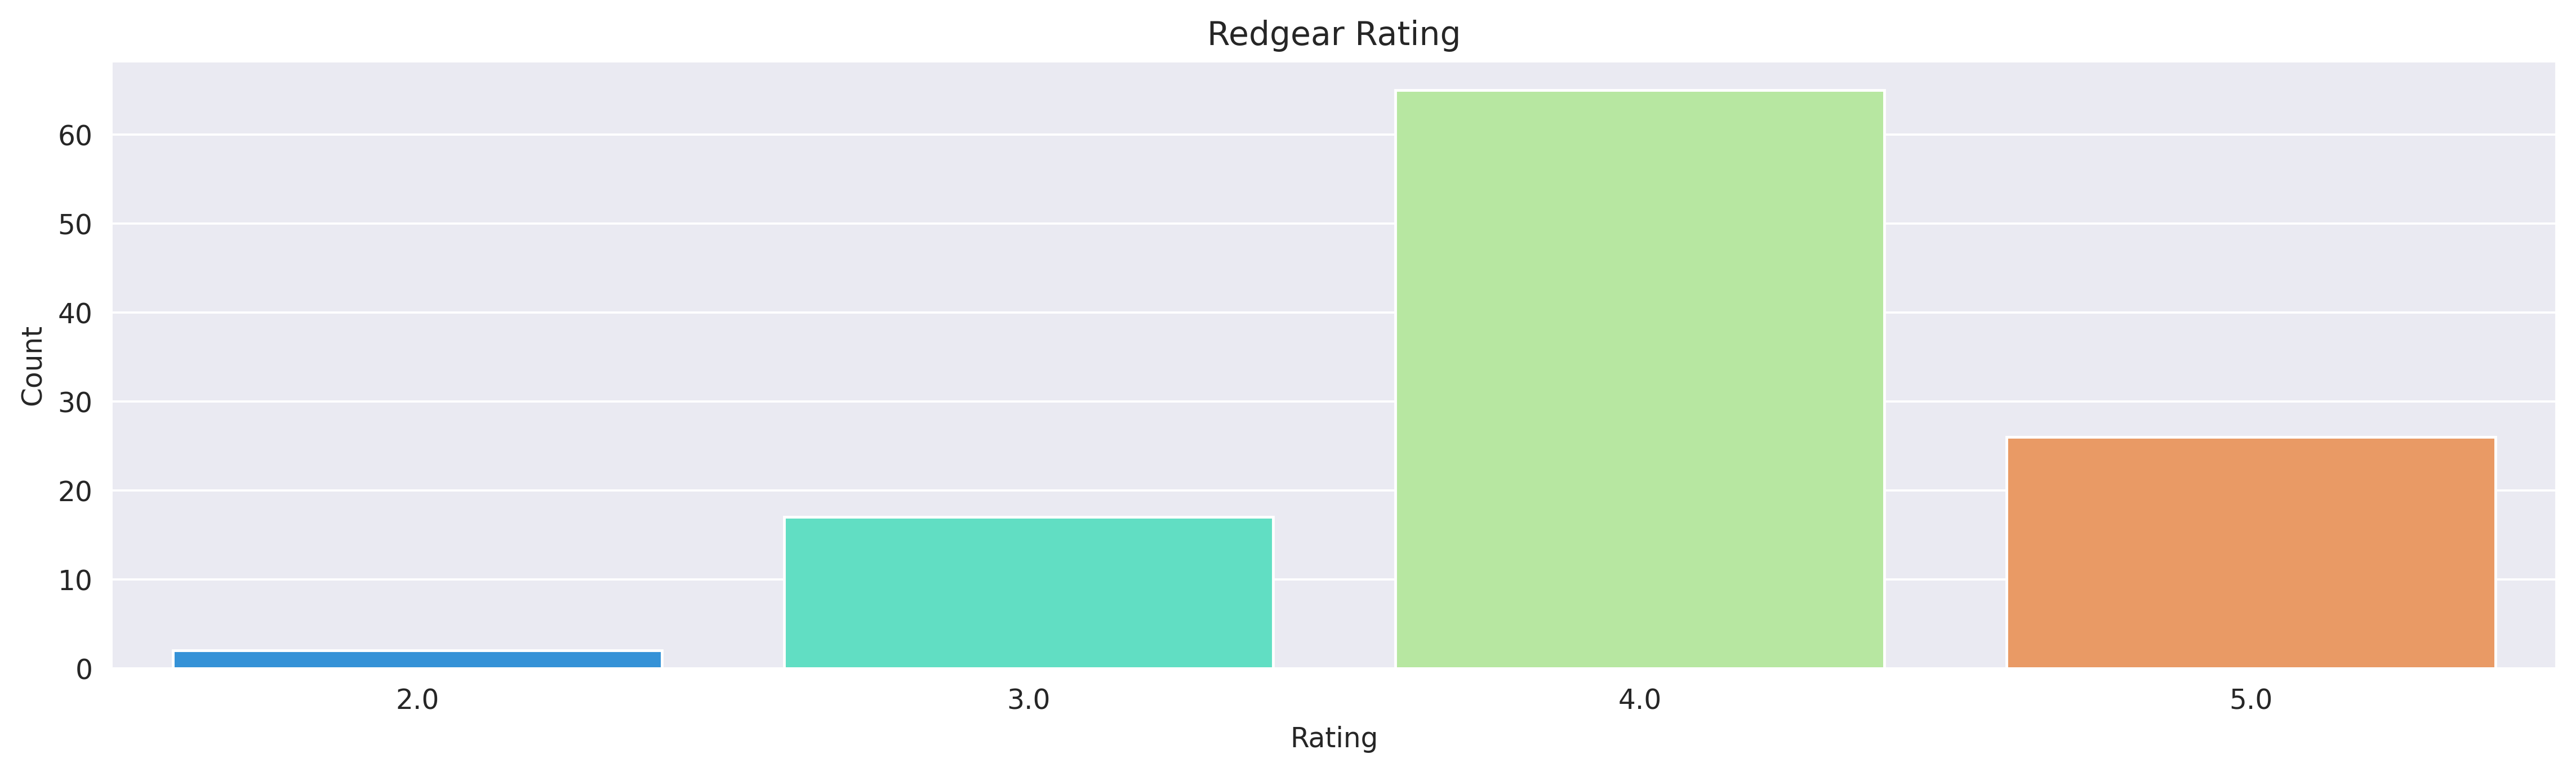

In [12]:
plt.title('Redgear Rating')
sns.barplot(x = ts['Rating'].value_counts().index, y = ts['Rating'].value_counts().values, palette = 'rainbow')
plt.xlabel('Rating')
plt.ylabel('Count')

#### Ploting Pieplot

<Axes: ylabel='Rating'>

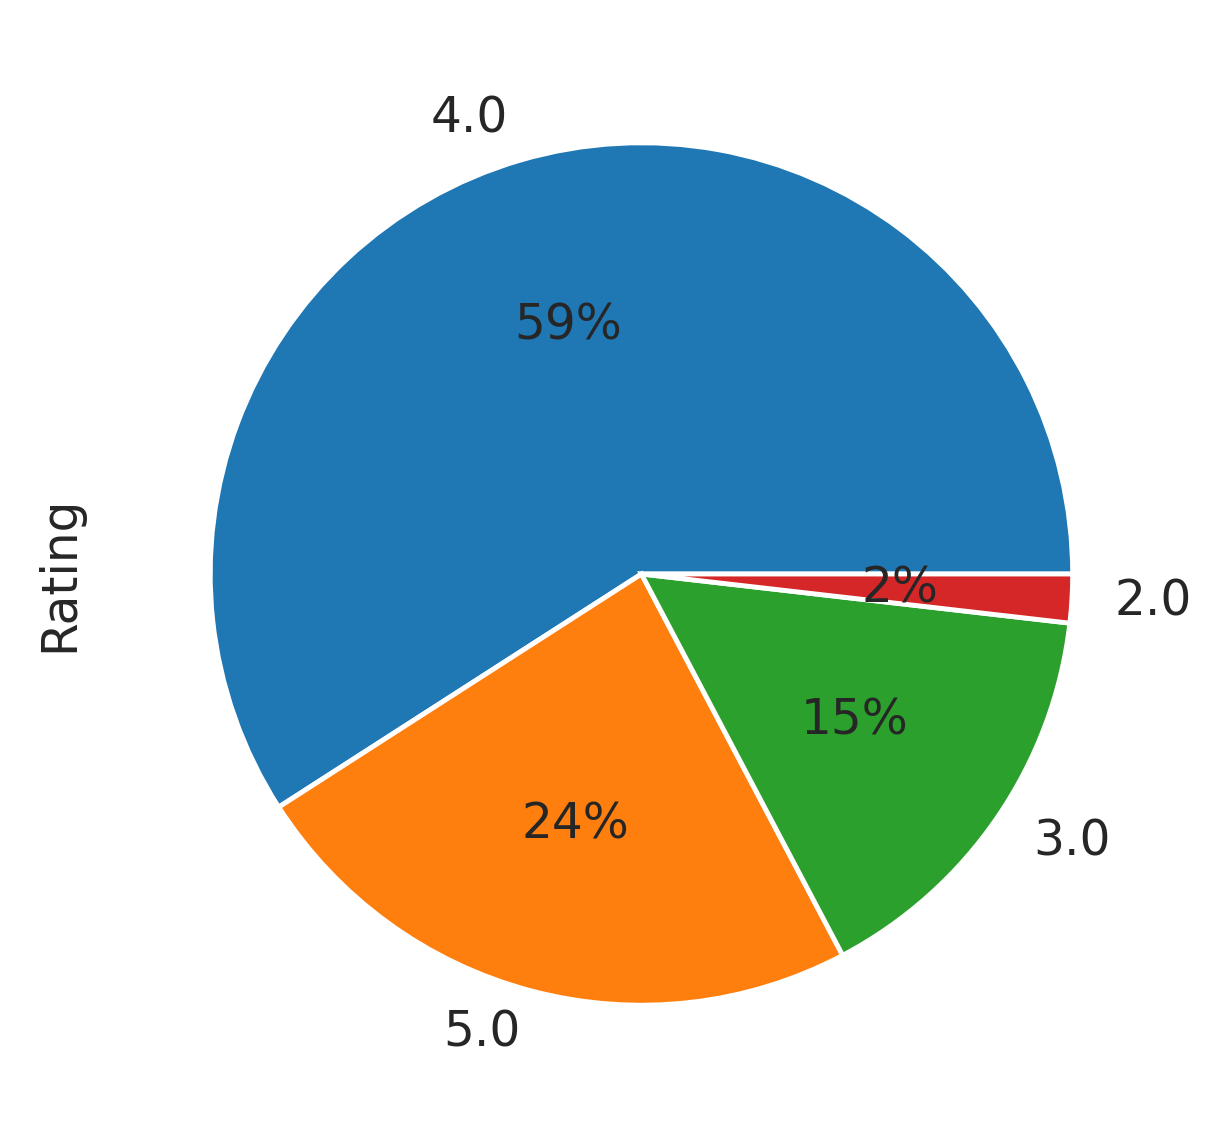

In [10]:
ts['Rating'].value_counts().plot(kind='pie',autopct='%1.00f%%')

#### Ploting Lineplot

<Axes: xlabel='Review_Date'>

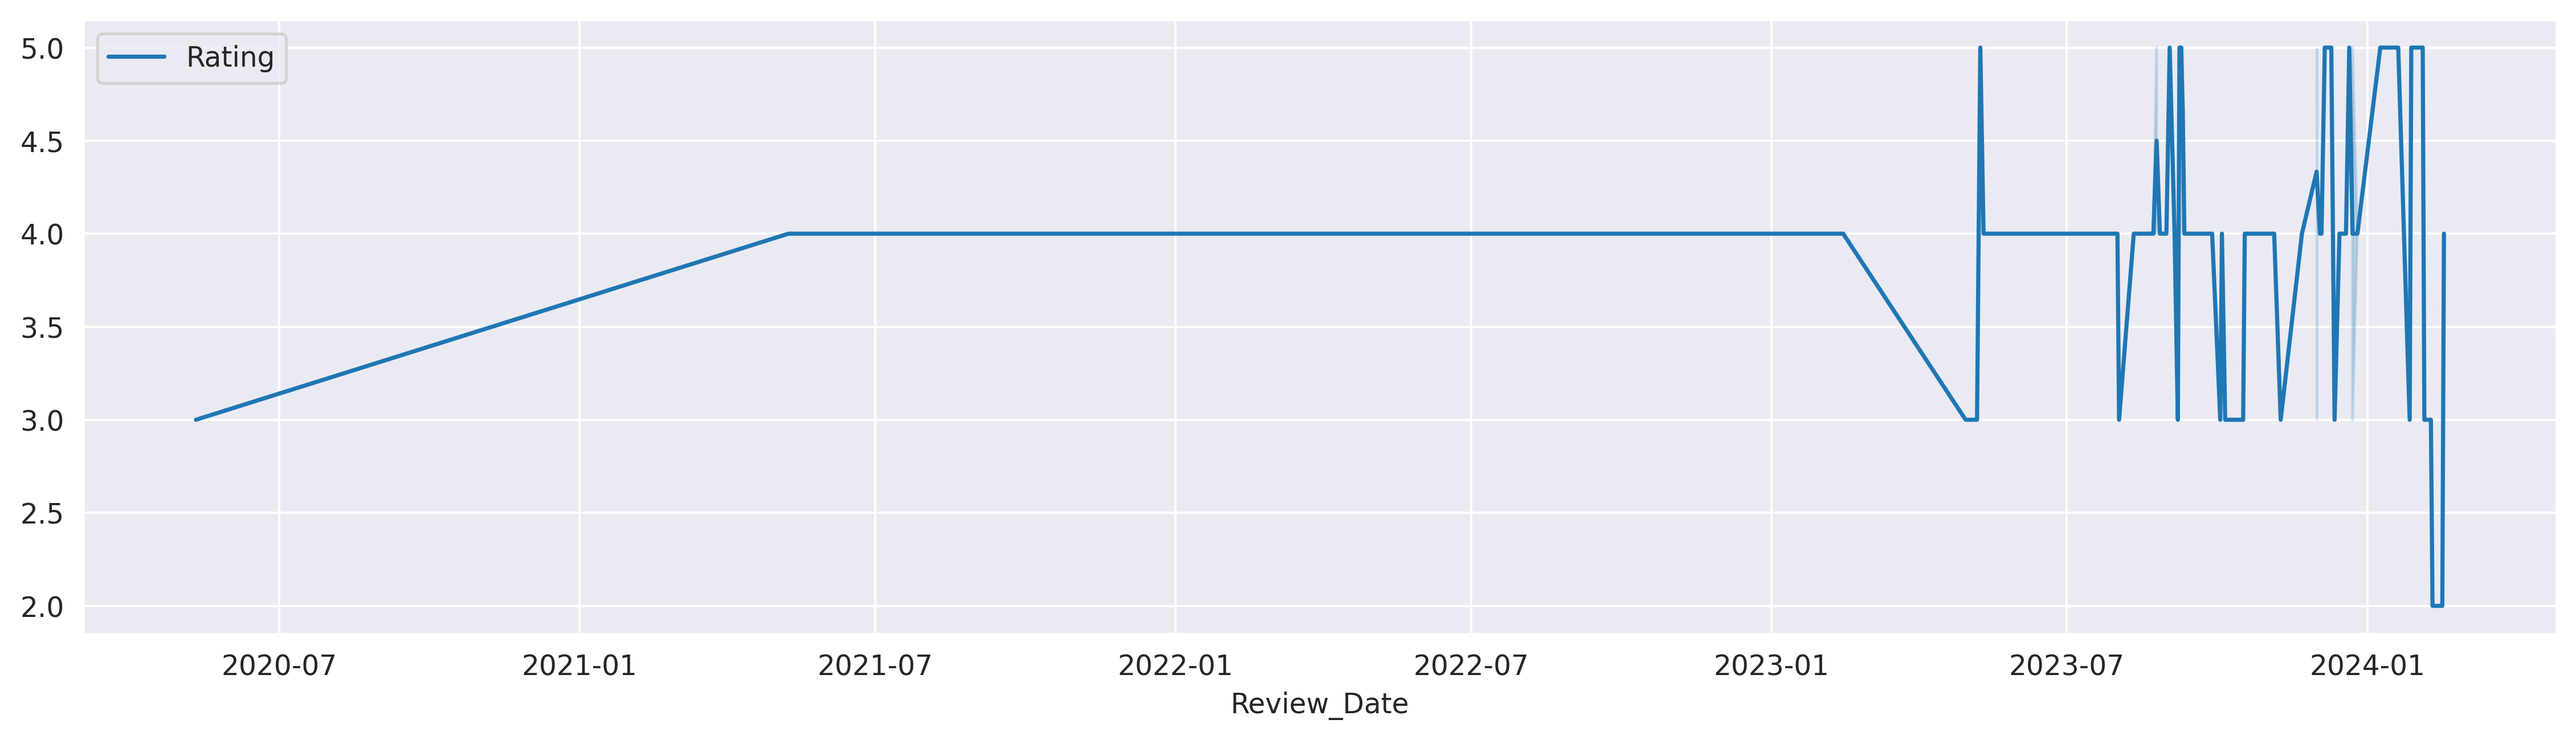

In [13]:
sns.lineplot(data= ts)

### Applying Lemmatization And Removing Stopword

In [14]:
def corpu(em, Text):
    lemma = WordNetLemmatizer()

    corpus = []

    for i in range(len(em)):
        msg = re.sub('[^a-zA-Z]',' ',em[Text][i])
        msg = msg.lower()
        msg = msg.split()

        msg = [lemma.lemmatize(i) for i in msg if i not in stopwords.words('english')]
        msg = ' '.join(msg)
        corpus.append(msg)

    return corpus

In [16]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [18]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [19]:
corpus = corpu(rg, 'Review')

corpus

['bought product got r using nearly hour day everyday past half year also using several headphone think one else would better rating product pro good built decent comfort best bass price segment tested brutal bass test top bass production yt ultimate headphone test multiple time throughout year new sensitivity frequency response distortion phase point even defeated numerous headphone friend price range k cable long help route microphone sensitivity good loud con cable braided tangle easily volume adjustment scroller side work occasion might product bit heavy feel uncomfortable longer session especially perspire sweat frequently good smaller session like hour overall rating conclusion budget around r probably best would get buy expect extreme top level performance headphone r k range',
 'first time bought product opened package volume control bit messed know assumed volume low bought view changed volume control work volume recently loud good quality comfort price mic quality good',
 'hu

### Performing Word Tokenize

In [20]:
def word_tok(corpus):
    word = []

    for i in corpus:
        words = word_tokenize(i)
        word.append(words)

    return word

In [22]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [23]:
word = word_tok(corpus)

word

[['bought',
  'product',
  'got',
  'r',
  'using',
  'nearly',
  'hour',
  'day',
  'everyday',
  'past',
  'half',
  'year',
  'also',
  'using',
  'several',
  'headphone',
  'think',
  'one',
  'else',
  'would',
  'better',
  'rating',
  'product',
  'pro',
  'good',
  'built',
  'decent',
  'comfort',
  'best',
  'bass',
  'price',
  'segment',
  'tested',
  'brutal',
  'bass',
  'test',
  'top',
  'bass',
  'production',
  'yt',
  'ultimate',
  'headphone',
  'test',
  'multiple',
  'time',
  'throughout',
  'year',
  'new',
  'sensitivity',
  'frequency',
  'response',
  'distortion',
  'phase',
  'point',
  'even',
  'defeated',
  'numerous',
  'headphone',
  'friend',
  'price',
  'range',
  'k',
  'cable',
  'long',
  'help',
  'route',
  'microphone',
  'sensitivity',
  'good',
  'loud',
  'con',
  'cable',
  'braided',
  'tangle',
  'easily',
  'volume',
  'adjustment',
  'scroller',
  'side',
  'work',
  'occasion',
  'might',
  'product',
  'bit',
  'heavy',
  'feel',
  

## Creating Word Cloud

In [24]:
def worldcloud(data):
    txt = ' '.join(data)
    stop = STOPWORDS

    wc = WordCloud(background_color='white',stopwords=stop).generate(txt)
    plt.imshow(wc)
    plt.axis('off')
    plt.title('worldcloud',size = 50)

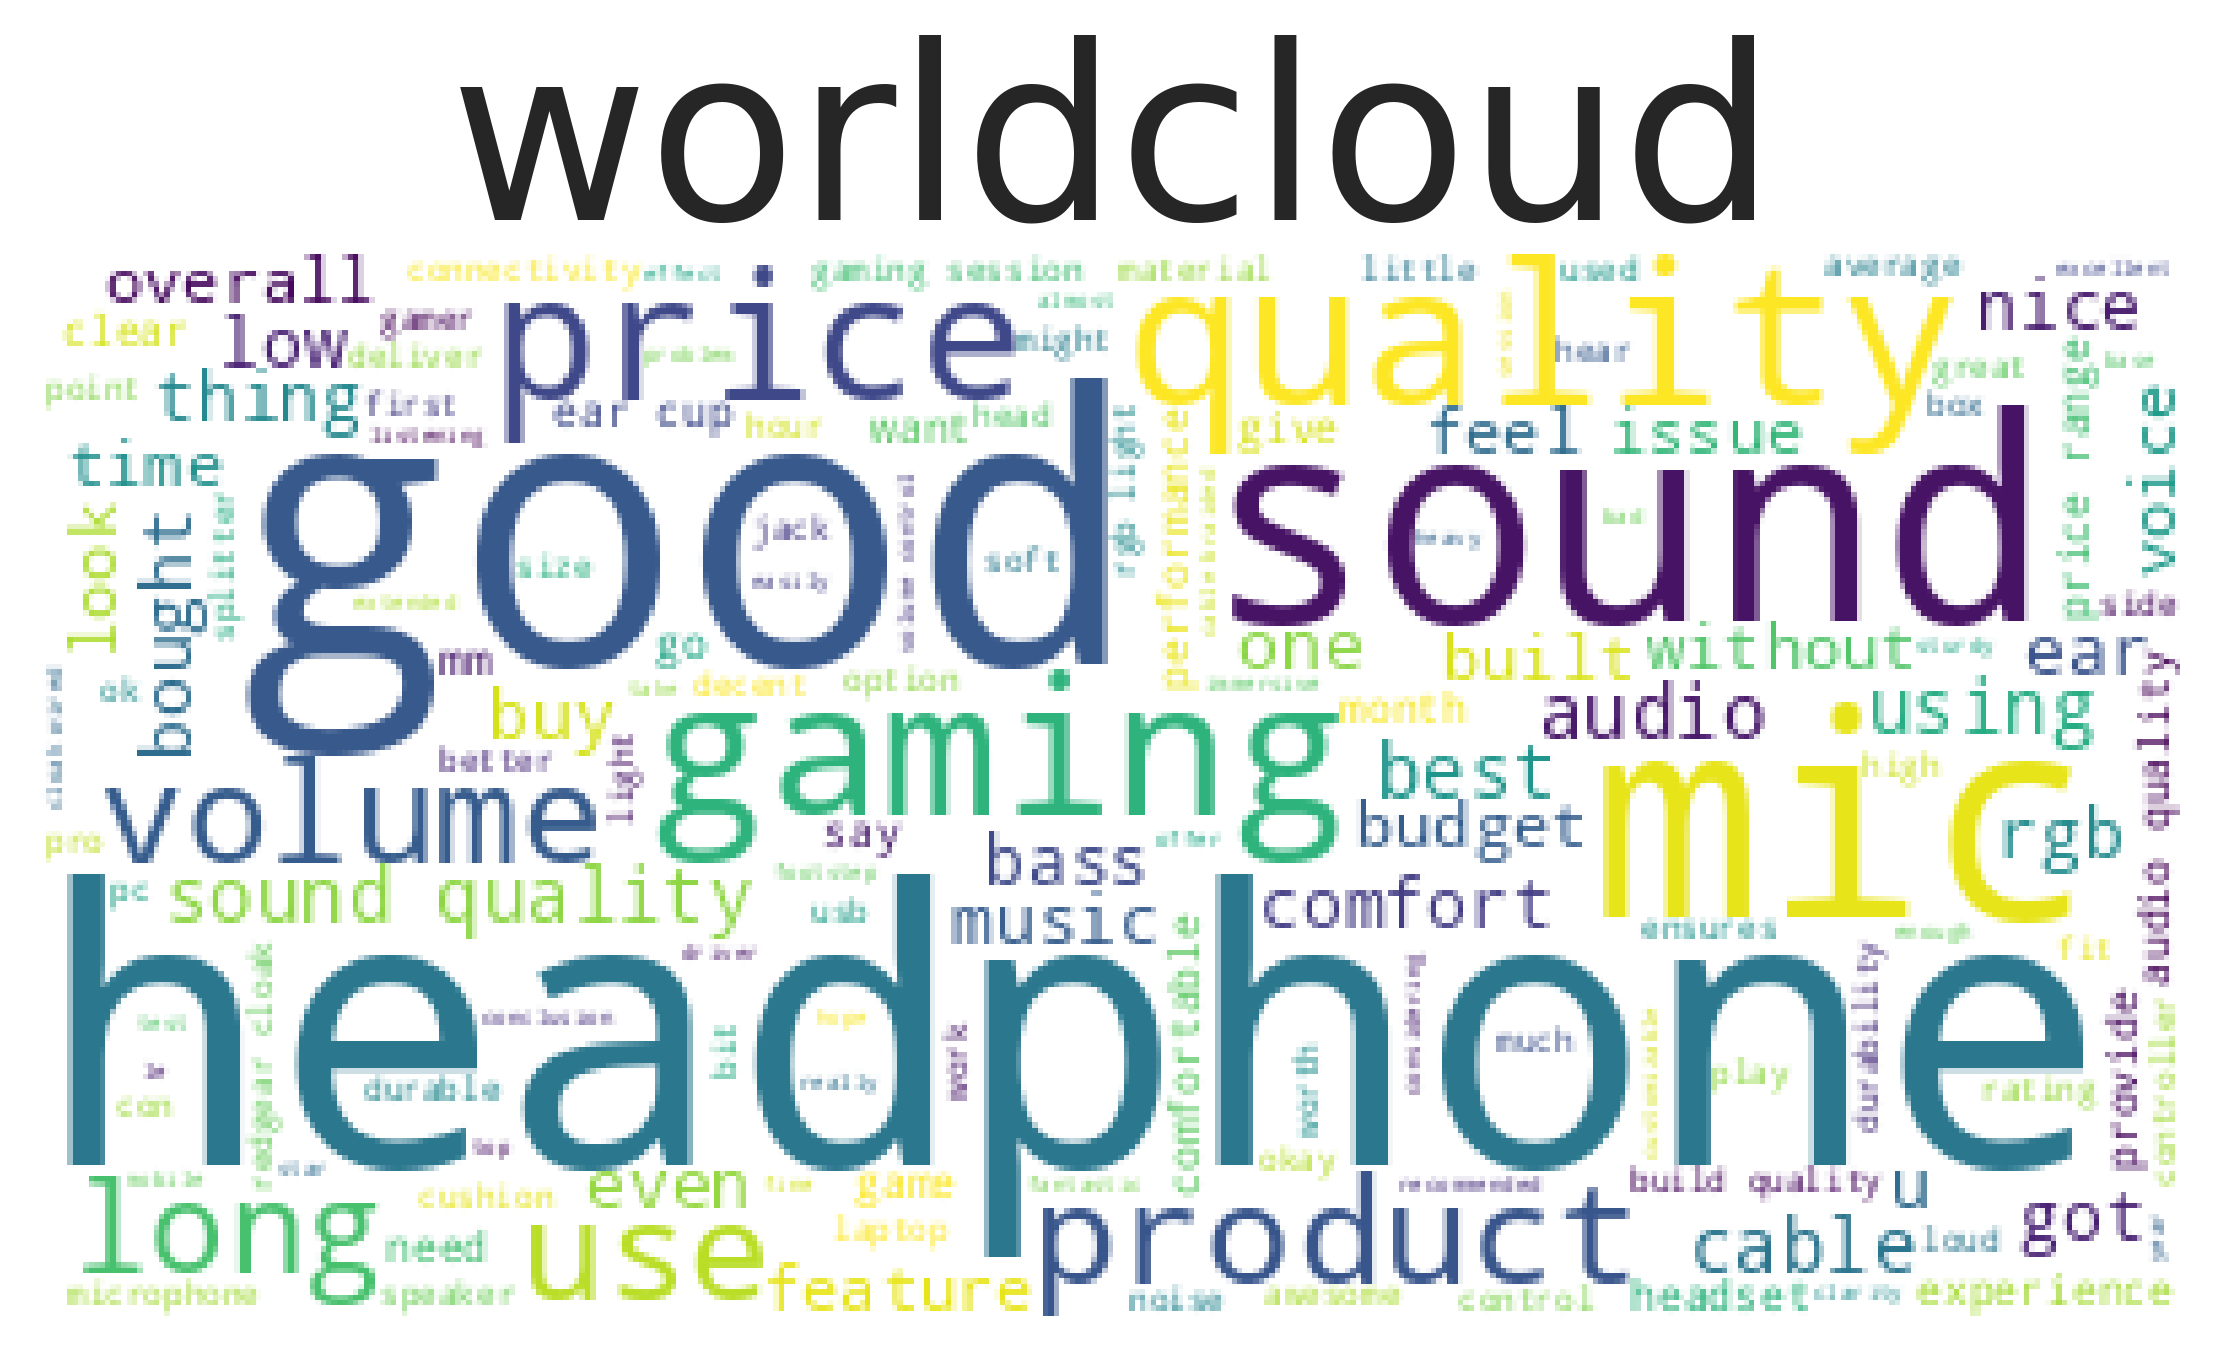

In [25]:
worldcloud(corpus)

## Performing Data Preprocesing

### Creating Bag Of Word's

In [26]:
cv = CountVectorizer()

x = cv.fit_transform(corpus)
x.toarray()

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [27]:
cv.get_feature_names_out()

array(['able', 'absolutely', 'acceptable', 'according', 'acctually',
       'accurate', 'activity', 'actually', 'add', 'added', 'additional',
       'adgestment', 'adjust', 'adjustable', 'adjusting', 'adjustment',
       'affect', 'affecting', 'affordable', 'afraid', 'aggressive', 'ala',
       'allign', 'allowing', 'allows', 'almost', 'also', 'although',
       'amazin', 'amazing', 'amazon', 'amplifier', 'amzon', 'annoying',
       'another', 'ant', 'anyone', 'anything', 'anyway', 'anyything',
       'apart', 'appears', 'apply', 'appreciate', 'around', 'assumed',
       'assuring', 'atleast', 'attending', 'attractive', 'audible',
       'audibleoverall', 'audience', 'audio', 'audiobalance', 'audiobass',
       'audiophiles', 'august', 'auto', 'available', 'average',
       'averagefoot', 'awaited', 'away', 'awesome', 'awsome',
       'background', 'backside', 'bad', 'balanced', 'band', 'bang',
       'bank', 'bar', 'base', 'basic', 'basis', 'bass', 'bassy', 'batter',
       'battery',

In [28]:
bow = pd.DataFrame(x.toarray(), columns=cv.get_feature_names_out())

bow

,able,absolutely,acceptable,according,acctually,accurate,activity,actually,add,added,...,writing,yea,yeah,year,yes,yet,youre,youtuber,yr,yt
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
106,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
107,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
108,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Creating Tf-Idf

In [29]:
tf = TfidfVectorizer()

x_tf = tf.fit_transform(corpus)

x_tf.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.10346864],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [30]:
tf.get_feature_names_out()

array(['able', 'absolutely', 'acceptable', 'according', 'acctually',
       'accurate', 'activity', 'actually', 'add', 'added', 'additional',
       'adgestment', 'adjust', 'adjustable', 'adjusting', 'adjustment',
       'affect', 'affecting', 'affordable', 'afraid', 'aggressive', 'ala',
       'allign', 'allowing', 'allows', 'almost', 'also', 'although',
       'amazin', 'amazing', 'amazon', 'amplifier', 'amzon', 'annoying',
       'another', 'ant', 'anyone', 'anything', 'anyway', 'anyything',
       'apart', 'appears', 'apply', 'appreciate', 'around', 'assumed',
       'assuring', 'atleast', 'attending', 'attractive', 'audible',
       'audibleoverall', 'audience', 'audio', 'audiobalance', 'audiobass',
       'audiophiles', 'august', 'auto', 'available', 'average',
       'averagefoot', 'awaited', 'away', 'awesome', 'awsome',
       'background', 'backside', 'bad', 'balanced', 'band', 'bang',
       'bank', 'bar', 'base', 'basic', 'basis', 'bass', 'bassy', 'batter',
       'battery',

In [31]:
tf_idf = pd.DataFrame(x_tf.toarray(), columns=tf.get_feature_names_out())

tf_idf

,able,absolutely,acceptable,according,acctually,accurate,activity,actually,add,added,...,writing,yea,yeah,year,yes,yet,youre,youtuber,yr,yt
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,...,0.0,0.0,0.0,0.184011,0.0,0.0,0.0,0.0,0.0,0.103469
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.068446,0.0,0.0,0.0,0.0,0.0,0.062026,0.073,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
106,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
107,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
108,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000


## Perform Sentimental Analysis

In [32]:
df_corpus = pd.DataFrame(corpus, columns= ['txt'])

df_corpus

,txt
0,bought product got r using nearly hour day eve...
1,first time bought product opened package volum...
2,huge easy fit overhead size good volume hoped ...
3,build headphone good voice low average product...
4,recently purchased redgear cloak wired rgb ear...
...,...
105,medium could loaded
106,good sound mic quality got long thick cable go...
107,almost month using get anything better bought ...
108,good product


In [33]:
df_corpus['sentiment']=df_corpus['txt'].apply(lambda x : TextBlob(x).sentiment.polarity)

df_corpus

,txt,sentiment
0,bought product got r using nearly hour day eve...,0.119990
1,first time bought product opened package volum...,0.350000
2,huge easy fit overhead size good volume hoped ...,0.346508
3,build headphone good voice low average product...,0.183333
4,recently purchased redgear cloak wired rgb ear...,0.253869
...,...,...
105,medium could loaded,0.000000
106,good sound mic quality got long thick cable go...,0.290000
107,almost month using get anything better bought ...,0.164286
108,good product,0.700000


### Sorting Review Into Negtive Or Positive

In [34]:
def assign_Result(ratings):
    if ratings < 0:
        result = 'negative'
    elif ratings >= 0:
        result = 'positive'

    return result

In [35]:
df_corpus['review_segment']=df_corpus['sentiment'].apply(assign_Result)

df_corpus

,txt,sentiment,review_segment
0,bought product got r using nearly hour day eve...,0.119990,positive
1,first time bought product opened package volum...,0.350000,positive
2,huge easy fit overhead size good volume hoped ...,0.346508,positive
3,build headphone good voice low average product...,0.183333,positive
4,recently purchased redgear cloak wired rgb ear...,0.253869,positive
...,...,...,...
105,medium could loaded,0.000000,positive
106,good sound mic quality got long thick cable go...,0.290000,positive
107,almost month using get anything better bought ...,0.164286,positive
108,good product,0.700000,positive


### visualizing The Results

<Axes: xlabel='None'>

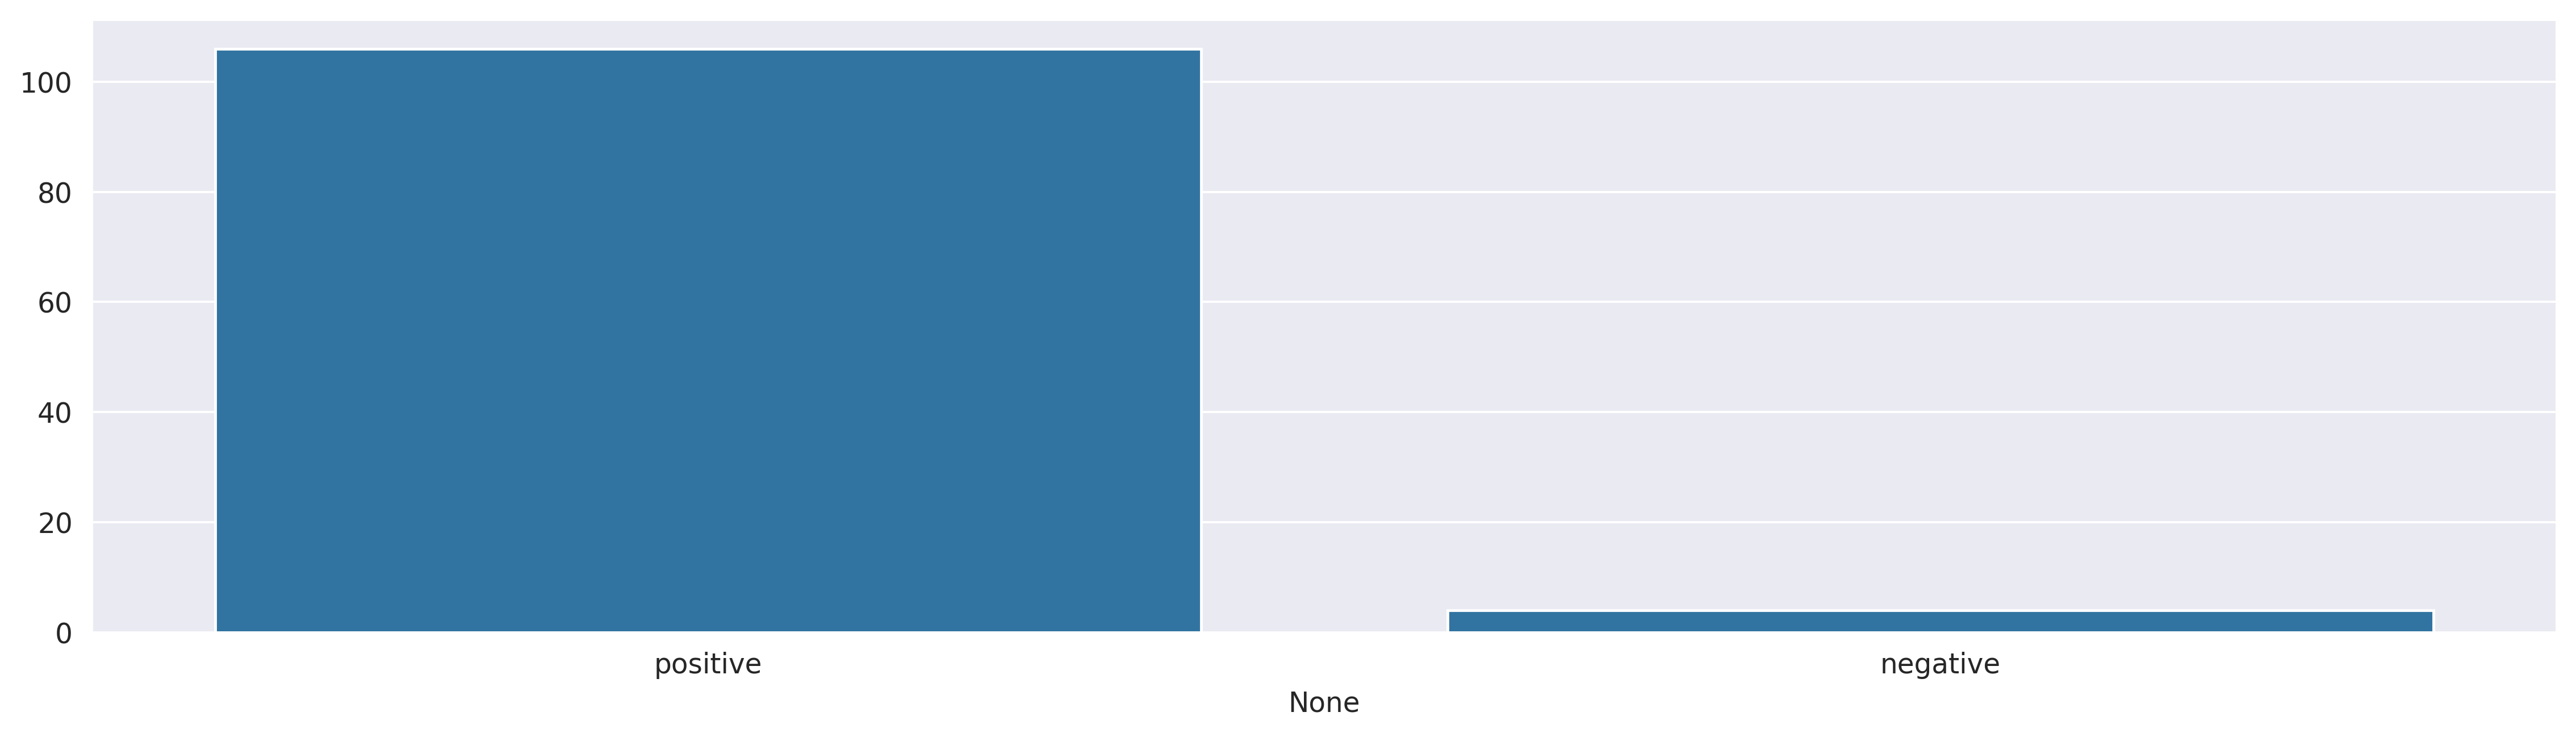

In [37]:
sns.barplot(x=df_corpus['review_segment'].value_counts().index, y=df_corpus['review_segment'].value_counts().values)

<Axes: ylabel='review_segment'>

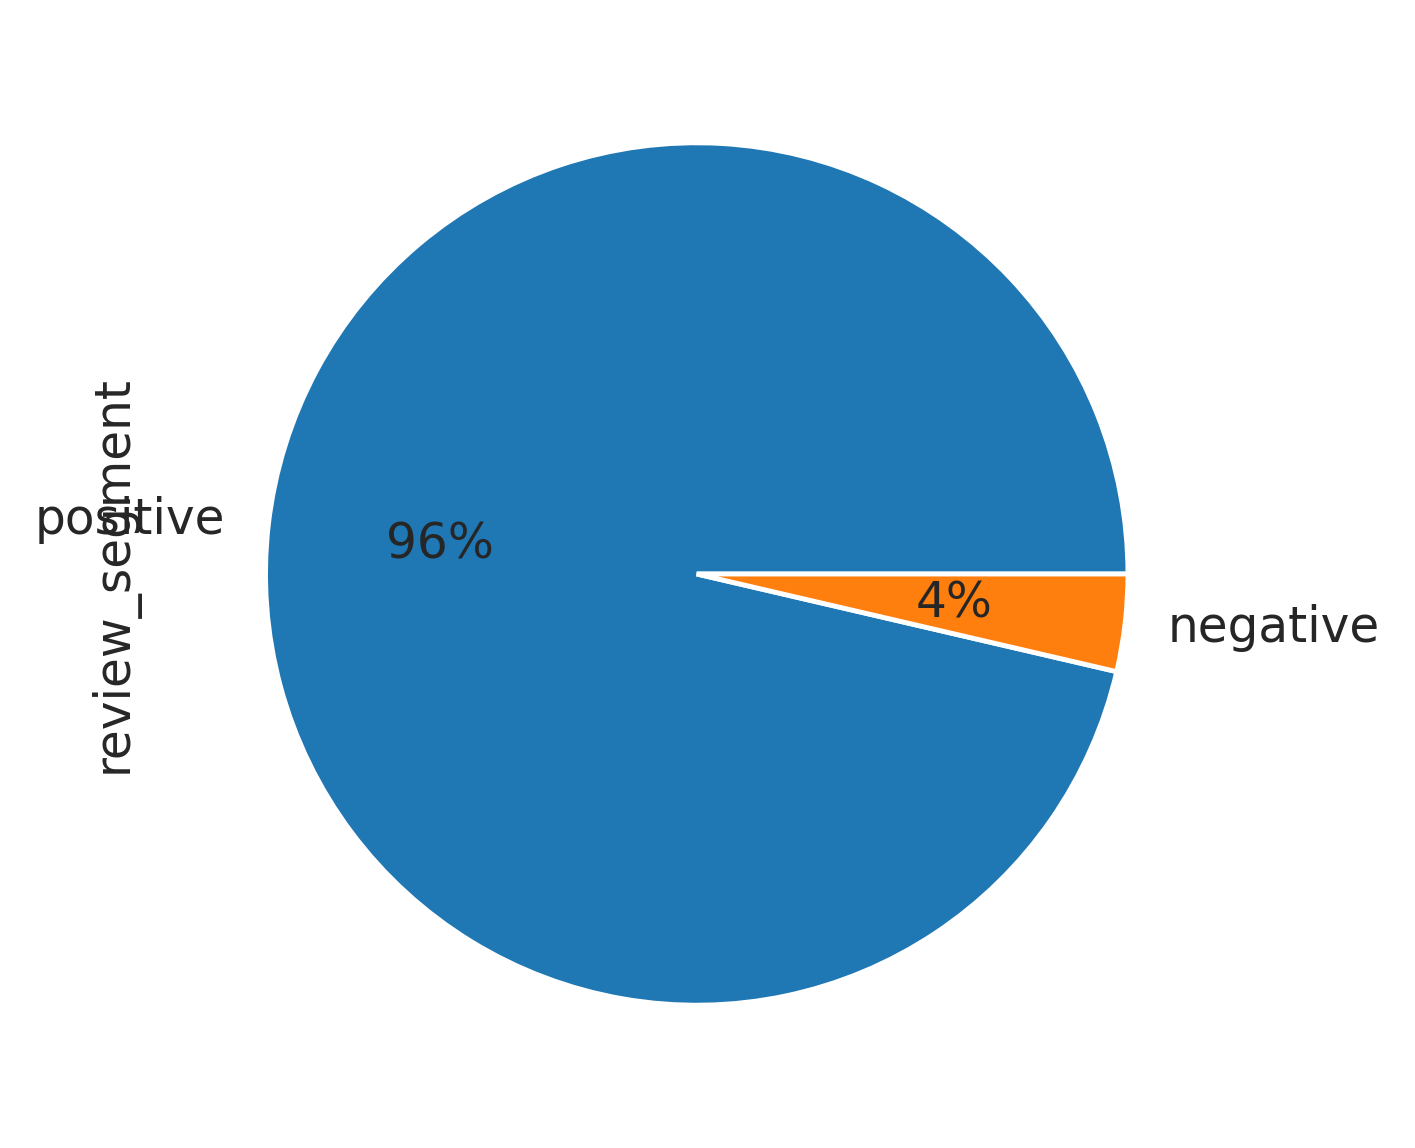

In [38]:
df_corpus['review_segment'].value_counts().plot(kind='pie',autopct='%1.00f%%')